In [1]:
from encapsulage import *
from linear import *
from module import *
from softmax import *
from tanh import *
from utils import *
from mltools import *

import numpy as np
import matplotlib.pyplot as plt
import random as rd

In [2]:
# Génération de données quelconques 
datax, datay = gen_arti(data_type=1)  # mélange de 4 gaussiennes
neuron = 10  # ou 10
datay[datay < 0] = 0
datax = add_bias (datax)

# Création du réseau
mse = MSELoss()
linear1 = Linear(datax.shape[1], neuron)
tan = TanH()
linear2 = Linear(neuron, datay.shape[1])
sigmoide = Sigmoide()

net = [linear1, tan, linear2, sigmoide]

# Initialisation pour descente de gradient
learning_rate = 0.1
nb_epochs = 100  # ou 1000
batch_size = None
if batch_size is None:
	batch_size = len(datay)
list_loss = []

for epoch in range(nb_epochs):
	# Forward pass
	res1 = linear1.forward(datax)
	res2 = tan.forward(res1)
	res3 = linear2.forward(res2)
	yhat = sigmoide.forward(res3)
	
	# Calcul de la loss
	last_loss = np.mean(mse.forward(datay, yhat))
	list_loss.append(last_loss)

	# Backward pass
	last_delta = mse.backward(datay, yhat)
	delta_sig = sigmoide.backward_delta(res3, last_delta)
	delta_lin = linear2.backward_delta(res2, delta_sig)
	delta_tan = tan.backward_delta(res1, delta_lin)

	linear1.backward_update_gradient(datax, delta_tan)
	linear2.backward_update_gradient(res2, delta_sig)

	# Mise à jour des paramètres
	linear1.update_parameters(learning_rate)
	linear2.update_parameters(learning_rate)
	linear1.zero_grad()
	linear2.zero_grad()
	
# Compute binary predictions
yhat_binary = (yhat > 0.5).astype(int)
print("Erreur de cross-entropie :", last_loss)

print("Accuracy :", np.sum(yhat_binary == datay) / len(datay))

Erreur de cross-entropie : 0.25000000148225177
Accuracy : 0.75


/Users/karimasadykova/Downloads/ML-Projet/ML-Projet/mltools.py:45: RuntimeWarning: invalid value encountered in double_scalars
  x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))


ValueError: arange: cannot compute length

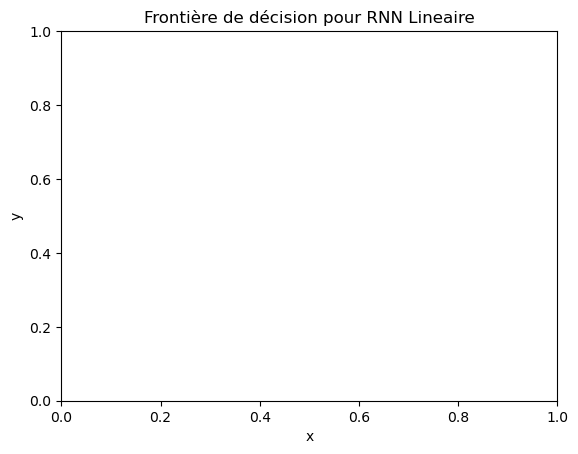

In [3]:
## Visualisation des données et de la frontière de décision pour un vecteur de poids w
plt.figure()
plt.title('Frontière de décision pour RNN Lineaire')
plt.xlabel('x')
plt.ylabel('y')

def predict(xtest):
		""" Prédiction sur des données. Il s'agit simplement d'un forward.
		"""
		# Ajout d'un biais aux données
		xtest = add_bias (xtest)

		# Phase passe forward
		res = net[0].forward(xtest)
		res = net[1].forward(res)
		res = net[2].forward(res)
		res = net[3].forward(res)

		return np.argmax(res, axis = 1)

# plot_frontiere(datax, lambda x : (sigmoide.forward(linear2.forward(tan.forward(linear1.forward(x)))) > 0.5),step=100)
plot_frontiere(datax, predict,step=100) #on soustrait 0.5 pour passer de valeurs binaires (0,1) à valeurs signée (-1,1)
plot_data(datax,datay)


Text(0.5, 0, "Nombre d'itérations")

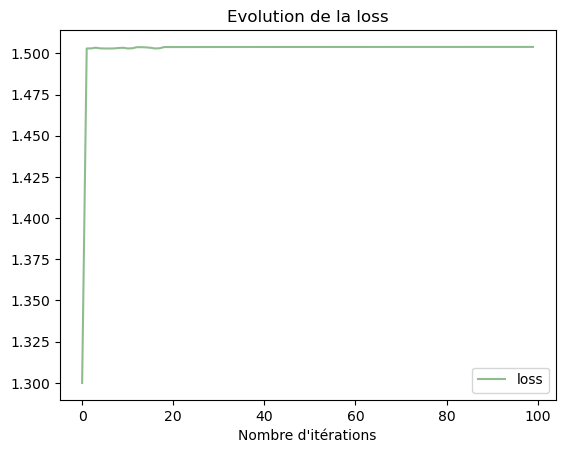

In [ ]:

# Evolution de la loss
plt.figure()
plt.title('Evolution de la loss')
plt.plot(list_loss, label='loss', c='darkseagreen')
plt.legend()
plt.xlabel('Nombre d\'itérations')

In [ ]:
class NonLin:
	""" Classe pour un classifieur non-linéaire par réseau de neurones.
	"""
	def fit(self, xtrain, ytrain, niter=100, gradient_step=1e-5, neuron=100):
		""" Classification non-linéaire sur les données d'apprentissage.
			@param xtrain: float array x array, données d'apprentissage
			@param ytrain: int array, labels sur les données d'apprentissage
			@param niter: int, nombre d'itérations
			@param gradient_step: float, pas de gradient
			@param neuron: nombre de neurones dans une couche
		"""
		# Ajout d'un biais aux données
		xtrain = add_bias (xtrain)

		# Récupération des tailles des entrées
		batch, output = ytrain.shape
		batch, input = xtrain.shape

		# Initialisation des couches du réseau et de la loss
		self.mse = MSELoss()
		self.linear_1 = Linear(input, neuron)
		self.tanh = TanH()
		self.linear_2 = Linear(neuron, output)
		self.sigmoide = Sigmoide()
		
		self.list_loss = []

		for i in range(niter):

			# ETAPE 1: Calcul de l'état du réseau (phase forward)
			res1 = self.linear_1.forward(xtrain)
			res2 = self.tanh.forward(res1)
			res3 = self.linear_2.forward(res2)
			res4 = self.sigmoide.forward(res3)

			# ETAPE 2: Phase backward (rétro-propagation du gradient de la loss
			#		  par rapport aux paramètres et aux entrées)
			last_delta = self.mse.backward(ytrain, res4)
			self.list_loss.append(np.mean( self.mse.forward(ytrain, res4) ))

			delta_sig = self.sigmoide.backward_delta(res3, last_delta)
			delta_lin = self.linear_2.backward_delta(res2, delta_sig)
			delta_tan = self.tanh.backward_delta(res1, delta_lin)

			self.linear_1.backward_update_gradient(xtrain, delta_tan)
			self.linear_2.backward_update_gradient(res2, delta_sig)
			# ETAPE 3: Mise à jour des paramètres du réseau (matrice de poids w)
			self.linear_1.update_parameters(gradient_step)
			self.linear_2.update_parameters(gradient_step)
			self.linear_1.zero_grad()
			self.linear_2.zero_grad()

			self.list_loss.append(np.mean( self.mse.forward(ytrain, res4) ))

		# Affichage de la loss
		print("\nErreur mse :", np.mean( self.mse.forward(ytrain, res4) ) )

	def predict(self, xtest):
		""" Prédiction sur des données. Il s'agit simplement d'un forward.
		"""
		# Ajout d'un biais aux données
		xtest = add_bias (xtest)

		# Phase passe forward
		res = self.linear_1.forward(xtest)
		res = self.tanh.forward(res)
		res = self.linear_2.forward(res)
		res = self.sigmoide.forward(res)

		return np.argmax(res, axis = 1)

In [ ]:
import time
from sklearn.discriminant_analysis import StandardScaler

def plot(datax, datay, model, name=''):
	""" Fonction d'affichage des données gen_arti et de la frontière de
		décision.
	"""
	plot_frontiere(datax,lambda x : model.predict(x),step=100)
	plot_data(datax,datay.reshape(1,-1)[0])
	plt.title(name)
	plt.show()

def mainNonLineaire(neuron=10, niter=1000, gradient_step=1e-3, batch_size=None):	
	# Création de données artificielles suivant 4 gaussiennes
	datax, datay = gen_arti(epsilon=0.1, data_type=1)
	
	# Descente de gradient batch par défaut
	if batch_size == None:
		batch_size = len(datay)
		
	# Normalisation des données
	scaler = StandardScaler()
	datax = scaler.fit_transform(datax)
	
	# One-Hot Encoding
	datay = np.array([ 0 if d == -1 else 1 for d in datay ])
	onehot = np.zeros((datay.size, 2))
	onehot[ np.arange(datay.size), datay ] = 1
	datay = onehot
	
	# Création et test sur un réseau de neurones non linéaire
	
	time_start = time.time()
	
	batch, output = datay.shape
	batch, input = datax.shape
	
	mse = MSELoss()
	linear_1 = Linear(input+1, neuron)
	tanh = TanH()
	linear_2 = Linear(neuron, output)
	sigmoide = Sigmoide()
	
	net = [linear_1, tanh, linear_2, sigmoide]
	
	nonlin = NonLin()
	# nonlin.SGD(net, mse, datax, datay, batch_size=batch_size, niter=niter, gradient_step=gradient_step)
	nonlin.fit(datax, datay, niter=1000, neuron=2)

	# Test sur les données d'apprentissage
	ypred = nonlin.predict(datax)
	datay = np.argmax(datay, axis=1)
	
	print("\nTemps d'exécution: ", time.time() - time_start )
	print("Score de bonne classification: ", np.mean( ypred == datay ))
	plot(datax, datay, nonlin, name='Regression non Linéaire, n_neurons = {}, niter = {}, gradient_step = {}'.format(neuron, niter, gradient_step))
	
	# Evolution de la loss
	plt.figure()
	plt.title('Evolution de la loss')
	plt.plot(nonlin.list_loss, label='loss', c='darkseagreen')
	plt.legend()
	plt.xlabel('Nombre d\'itérations')

/Users/karimasadykova/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



Erreur mse : 0.6205727035242031

Temps d'exécution:  0.29537034034729004
Score de bonne classification:  0.502


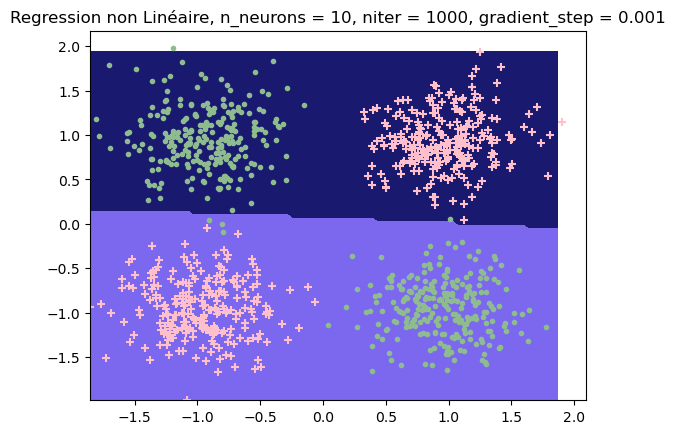

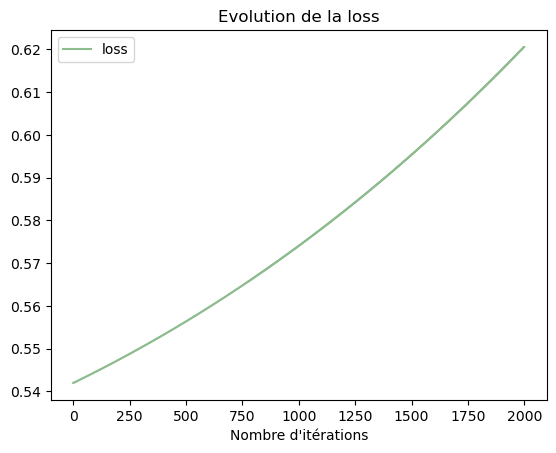

In [ ]:
mainNonLineaire()